### Using Data Augmentation for increasing the dataset size

In [1]:
import os
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
#from helpers import visualize
%matplotlib inline

In [2]:
def visualize(input_arr,labels,num_imgs=9):
    plot_size=int(np.ceil(num_imgs/4))
    fig = plt.figure(figsize=(12,12))
    if len(input_arr.shape)==4:
        num_imgs=input_arr.shape[0]
    else:
        num_imgs=1
        input_arr=np.expand_dims(input_arr,axis=0)
        labels=[labels]
    for i in range(num_imgs):
      plt.subplot(4,plot_size,i+1)
      plt.tight_layout()
      img = input_arr[i]

      img = np.rollaxis(img,0,3)
      plt.imshow(img, interpolation='none')
      plt.title("class_label: {}".format(labels[i]))
      plt.xticks([])
      plt.yticks([])

In [3]:
class DatasetLoader(Dataset):
    """ Dataset Class Wrapper """

    def __init__(self, root_path, data_dir, annotation_file,data_type='train', \
                 data_transform=None,label_transform=None):
        """
        Args:
            root_path (string):  the parent folder path
            annotation_file (string):  csv/txt file which has the 
                                        dataset labels
            data_type(string): the type of data-train,val,test
            data_transform: The trasforms to apply to data
            label_transform: The transforms to apply to label

        """
        
        self.data_path = os.path.join(root_path,data_dir,data_type)
        self.label_path = os.path.join(root_path,annotation_file)
        self.data_transform = data_transform
        self._load_data()

    def _load_data(self):
        '''
        function to load the data in the format of [[img_name_1,label_1],
        [img_name_2,label_2],.....[img_name_n,label_n]]
        '''
        self.labels = pd.read_csv(self.label_path)
        
        self.loaded_data = []
        for i in range(self.labels.shape[0]):
            img_name = os.path.join(self.data_path, self.labels['img_names'][i])
            label = self.labels['labels'][i]
            self.loaded_data.append((img_name,label))

    def __len__(self):
        return len(self.loaded_data)

    def __getitem__(self, idx):

        idx = idx % len(self.loaded_data)
       
        img_name,label = self.loaded_data[idx]  
        
        img = Image.open(img_name)
        if type(self.data_transform)==list:
            data=[]
            labels=[]
            for tfm in self.data_transform:
                img_ = tfm(img.copy())
                data.append(img_)
                labels.append(label)
            labels = torch.LongTensor(labels)
        
            return torch.stack(data, dim=0), labels
        else:
            img_ = self.data_transform(img.copy())
            
        return img_,label


In [4]:
root_path=r'D:\youtube\2021\data_aug_pytorch'
data_dir='dogs-vs-cats'
annotation_file='train_labels_mini.csv'


### Transformation for increasing dataset

In [5]:
t0=transforms.Compose([transforms.Resize((128,128)),
                                        transforms.ToTensor()])
t1=transforms.Compose([t0,transforms.RandomPerspective(distortion_scale=0.4, p=1.0)])
t2=transforms.Compose([transforms.Resize((128,128)),transforms.RandomCrop(96),t0])
t3=transforms.Compose([t0,transforms.RandomRotation((0,180))])
transform_tr=[t0,t1,t2,t3]


In [6]:
training_dataset=DatasetLoader(root_path,data_dir,annotation_file,data_type='train',\
                          data_transform=transform_tr)
print('length of dataset: ', len(training_dataset))

length of dataset:  400


C:\Users\uid38717\Anaconda3\envs\pytorch_env\lib\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ..\aten\src\ATen\LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


torch.Size([4, 3, 128, 128]) tensor([0, 0, 0, 0])


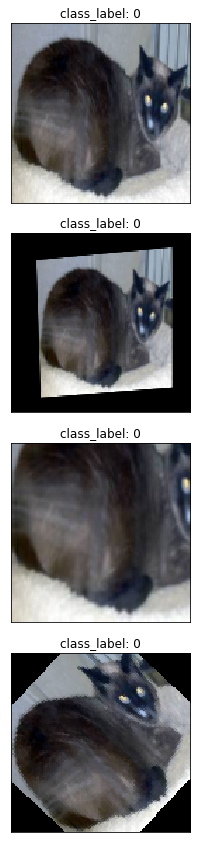

In [7]:
img,label=training_dataset[10]
print(img.shape,label)
visualize(img.numpy(),label,num_imgs=1)

In [8]:
train_dataloader = DataLoader(training_dataset, batch_size=12, shuffle=True)
print(len(train_dataloader))

34


In [9]:
data,label=next(iter(train_dataloader))
print(data.shape)

torch.Size([12, 4, 3, 128, 128])


In [10]:
from torch.utils.data.dataloader import default_collate


In [11]:
train_dataloader = DataLoader(training_dataset,collate_fn=default_collate, batch_size=12, shuffle=True)
print(len(train_dataloader))

34


In [12]:
data,label=next(iter(train_dataloader))
print(data.shape,label.shape)

torch.Size([12, 4, 3, 128, 128]) torch.Size([12, 4])


In [13]:
def my_collate_func(batch):
    batch = default_collate(batch)
    #assert(len(batch) == 2)
    batch_size, num_aug, channels, height, width = batch[0].size()
    batch[0] = batch[0].view([batch_size * num_aug, channels, height, width])
    batch[1] = batch[1].view([batch_size * num_aug])
    return batch

In [14]:
train_dataloader = DataLoader(training_dataset,collate_fn=my_collate_func, batch_size=12, shuffle=True)
print(len(train_dataloader))

34


In [15]:
data,label=next(iter(train_dataloader))
print(data.shape,label.shape)

torch.Size([48, 3, 128, 128]) torch.Size([48])


In [16]:
label

tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

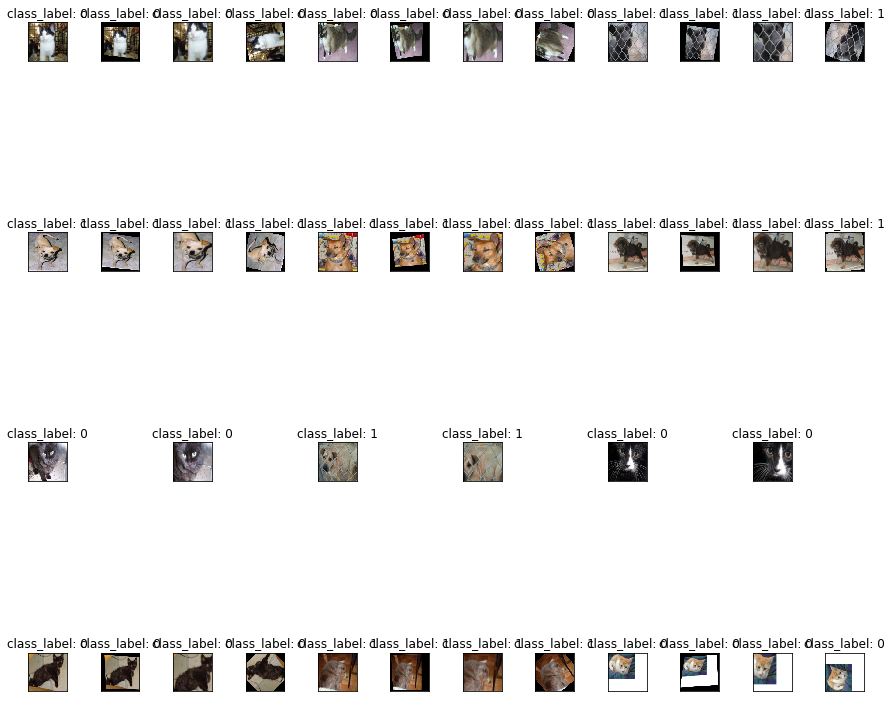

In [21]:
visualize(data.numpy(),label,num_imgs=48)

#### if we want we can shuffle the tensors

In [17]:

idx = torch.randperm(data.shape[0])
data_shuff = data[idx].view(data.size())

In [18]:
label_shuff = label[idx].view(label.size())

In [19]:
print(data_shuff.shape)
print(label_shuff.shape)

torch.Size([48, 3, 128, 128])
torch.Size([48])


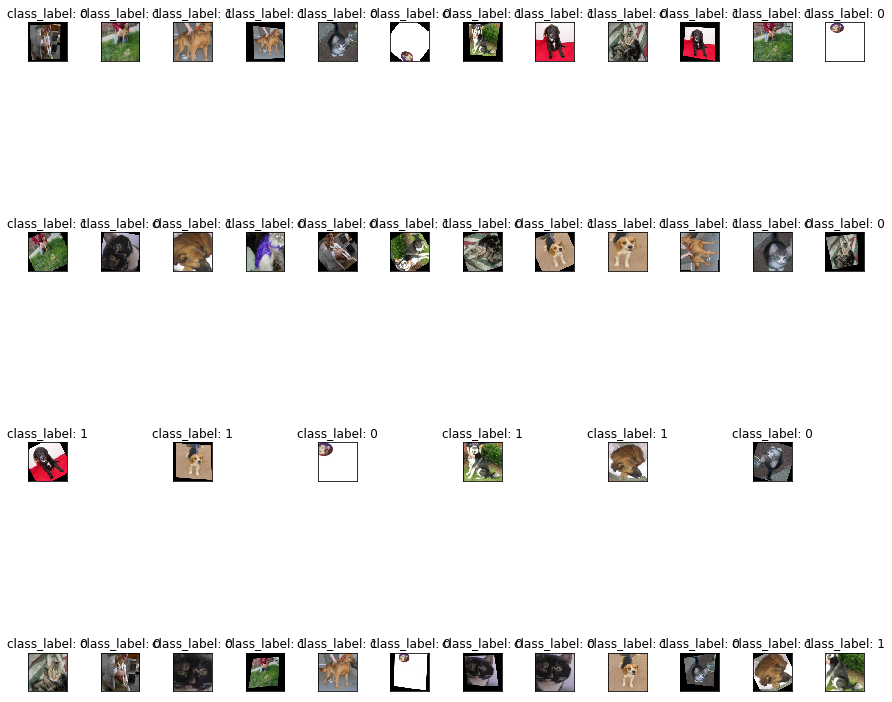

In [20]:
visualize(data_shuff.numpy(),label_shuff,num_imgs=48)

In [22]:
label_shuff

tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1])